In [1]:
"""
Created on Mon Apr 13 11:34:26 2020

Script for lesson 6 of "Friends of Tracking" #FoT

Data can be found at: https://github.com/metrica-sports/sample-data

Accompanying video tutorials can be found here: https://www.youtube.com/watch?v=5X1cSehLg6s

GitHub repo: https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking

@author: Laurie Shaw (@EightyFivePoint)
"""

import fotd_modules.Metrica_IO as mio
import fotd_modules.Metrica_Viz as mviz
import fotd_modules.Metrica_Velocities as mvel
import fotd_modules.Metrica_PitchControl as mpc
import numpy as np

# set up initial path to data
DATADIR = '/PATH/TO/WHERE/YOU/SAVED/THE/SAMPLE/DATA'

# I am looking at sample match 1 (Laurie used game 2!)
game_id = 1 

# read in the event data
events = mio.read_event_data(DATADIR,game_id)

# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

Reading team: home
Reading team: away


In [2]:
#**** NOTE *****
# the default filter set in Metrica_Velocities.py (filter_='Savitzky-Golay') produce an error 
# for certain version(s) of numpy, then use the trick below, setting 'moving_average' filter:
#***************
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True,filter_='moving_average')
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving_average')

In [3]:
# get all shots goals in the match
shots = events[events['Type']=='SHOT']

# accordingly all goals
goals = shots[shots['Subtype'].str.contains('-GOAL')].copy()
print(goals)

      Team  Type              Subtype  Period  Start Frame  Start Time [s]  \
34    Home  SHOT  HEAD-ON TARGET-GOAL       1         2289           91.56   
1114  Home  SHOT       ON TARGET-GOAL       2        90005         3600.20   
1213  Home  SHOT       ON TARGET-GOAL       2        99032         3961.28   

      End Frame  End Time [s]      From   To  Start X  Start Y  End X  End Y  
34         2309         92.36   Player9  NaN    44.52     2.04  54.06  -3.40  
1114      90026       3601.04  Player10  NaN    44.52   -12.92  53.00   2.72  
1213      99046       3961.84   Player9  NaN    50.88     2.72  54.06   0.68  


<h4> Analysis of a passing sequence </h4> 

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28e9efeba88>)

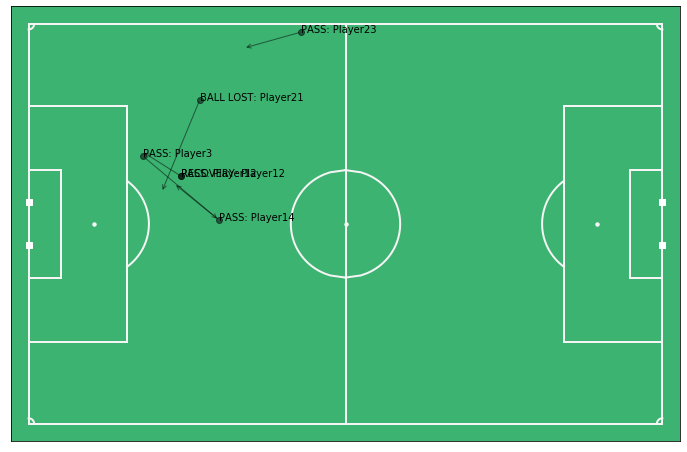

In [4]:
# plot all events (passes) of this play:
mviz.plot_events( events.loc[1668:1673], color='k', indicators = ['Marker','Arrow'], annotate=True )

In [5]:
# first get model parameters
params = mpc.default_model_params(3) # see Metrica_PitchControl module
params

{'max_player_accel': 7.0,
 'max_player_speed': 5.0,
 'reaction_time': 0.7,
 'tti_sigma': 0.45,
 'kappa_def': 1.0,
 'lambda_att': 4.3,
 'lambda_def': 4.3,
 'average_ball_speed': 15.0,
 'int_dt': 0.04,
 'max_int_time': 10,
 'model_converge_tol': 0.01,
 'time_to_control_att': 3.3202550055547313,
 'time_to_control_def': 3.3202550055547313}

In [6]:
# params: dictionary of parameters required to determine and calculate the model
# Just check that parameters stored as dict:
type(params) 

dict

<h4> Custom implementation using Laurie's Pitch Control (Off the ball runs importance) </h4>
<br> Before any analysis commences, I've had a look at potential interesting plays from this game (game 1) that could help me better demonstrate -from a football viewpoint- what the pitch might have looked like if a player had NOT made a (off the ball) run. <br><br>
The left fullback (Player 22) of the Away team was actively involved in his team's attacking plays. Eventually, helping me spot a really useful example to illustrate the importance of off the ball runs (regardless of whether he received the ball or not)

A thorough demonstration that details each step of this process can be found here:  [Twitter thread](https://twitter.com/malovits/status/1259407236708864000) <br> 

In [7]:
# Looked at start time of the particular example in events
# Accordingly, keep the corresponding time in tracking data

# (Eventually, the plan is to alter x,y values of player22 as if he hadn't make that run)

# Away team - Indices of the passing sequence of interest:
tr_away = tracking_away[ (tracking_away['Time [s]'] > 3325 )& (tracking_away['Time [s]'] < 3340) ]
tr_away

# Similarly, to loc. indices for Home team during that particular play:
tr_home = tracking_home[ (tracking_home['Time [s]'] > 3325 )& (tracking_home['Time [s]'] < 3340) ]

In [8]:
# Away team - keep the corresponding time in tracking data:
starting_x = tr_away.loc[ 83200 , 'Away_22_x' ]
starting_y = tr_away.loc[ 83200 , 'Away_22_y' ]

# creating copy of series 
new_away = tracking_away.copy() 

# Make player 22 (left fullback, 'stand still' as of a certain moment...(instant 83200)
new_away.loc[83200:83498, 'Away_22_x'] = starting_x
new_away.loc[83200:83498, 'Away_22_y'] = starting_y

# OR even better, a more realistic scenario... Have him tucking into midfield; instead of standing still:
for i in range (83201,83498):
    # trick to move towards midfield ("small steps"):
    position_cum = new_away.loc[i-1, 'Away_22_y'] + 0.035 
    new_away.loc[i, 'Away_22_y'] = position_cum

    
new_away.loc[83200:83498, 'Away_22_vx'] = 0
new_away.loc[83200:83498, 'Away_22_vy'] = 0
new_away.loc[83200:83498, 'Away_22_speed'] = 0

<h5>Prior to utilizing the Pitch Control model, it's handy to have a visual check to see the original and what-if scenarios in 2D </h5>

In [10]:
# Making first movie of what I want to demonstrate...

## Original play ##

#first, where to save the movie(s) (I chose to save them in the same DIR where I keep metrica_data)
PLOTDIR = DATADIR

mviz.save_match_clip(tracking_home.iloc[83126:83400],tracking_away.iloc[83126:83400],
                     PLOTDIR,fname='original_run',include_player_velocities=False)

Generating movie...done


In [11]:
# Making the WHAT-IF movie of what I want to demonstrate...

## Tucking into midfield area (instead) ##

mviz.save_match_clip(tracking_home.iloc[83127:83400],new_away.iloc[83127:83400],
                     PLOTDIR,fname='what_if2',include_player_velocities=False)

Generating movie...done


<h5> Plot evaluated pitch control surfaces on each case (Original, What-if scenario) </h5>
 Evaluated pitch control surface just before the final pass of the possession we are looking at.

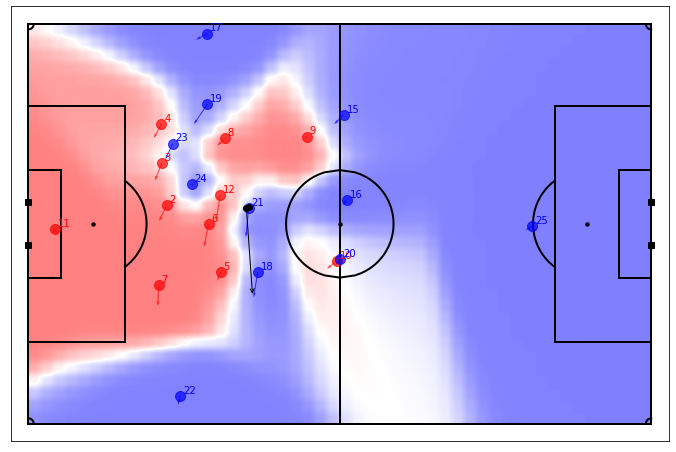

In [13]:
# THE ACTUAL ONE - PASS just before the final pass to player 22 (the switch of play that I don't need to show)

# evaluated pitch control surface for 1st pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(1040, events, tracking_home, 
                                                        tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
# plot pitch control surface for first pass
mviz.plot_pitchcontrol_for_event( 1040, events,  tracking_home, tracking_away, PPCF, xgrid, ygrid, annotate=True );

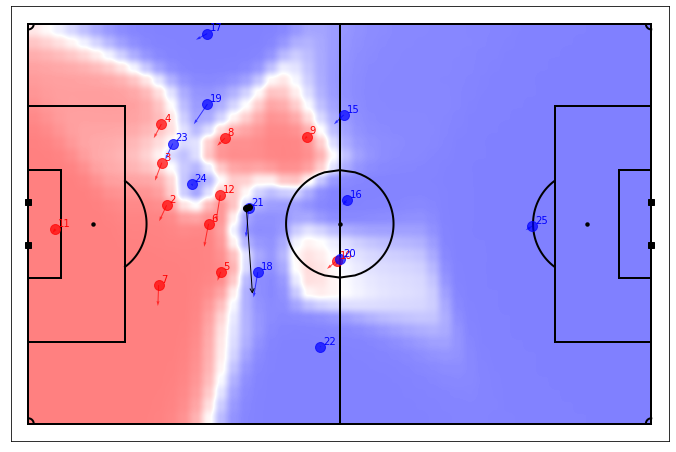

In [14]:
# WHAT IF... player 22 has not made that run....
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(1040, events, tracking_home, 
                                                        new_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
# plot pitch control surface for first pass
mviz.plot_pitchcontrol_for_event( 1040, events,  tracking_home, new_away, PPCF, xgrid, ygrid, annotate=True );

<h4> Back to Laurie's tutorial </h4>

<h5> In Jupyter notebooks, if you want to see the actual value(s) (probability of retain ball possession) of the pitch control surface you can use <br> %matplotlib notebook magic  </h5>
In this way, as you move your cursor around the field, you will be able to inspect these values (as Laurie does in his video)

In [15]:
# Note that %matplotlib notebook magic renders interactive plot:
%matplotlib notebook 

# And thus be able see the actual value of the pitch control surface 
# appear as you move your cursor around the field (as Laurie does in his video, in Spyder you can see them by-default)

In [16]:
# Plus, a trick to get consistent sizes (returns way to large plot, otherwise): 

import matplotlib as mpl

mpl.rcParams['savefig.dpi'] = 60 # As %matplotlib notebook used figure.dpi
mpl.rcParams['figure.dpi'] = 60

<IPython.core.display.Javascript object>


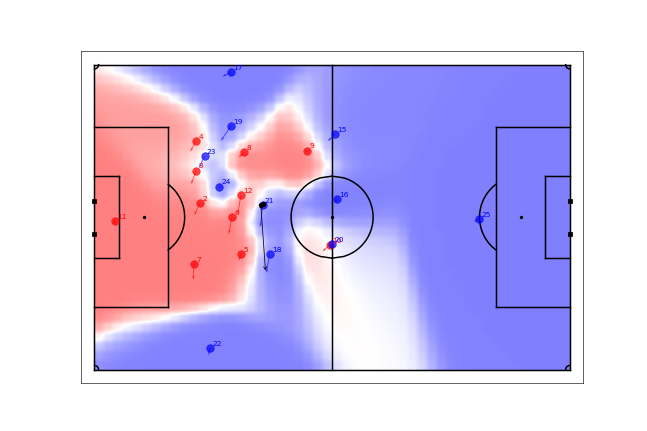

(<Figure size 720x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28ea53bb548>)

In [17]:
# Again here I am using my example - the original 

# evaluated pitch control surface for 1st pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(1040, events, tracking_home, 
                                                        tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
# plot pitch control surface for first pass
mviz.plot_pitchcontrol_for_event( 1040, events,  tracking_home, tracking_away, PPCF, xgrid, ygrid, annotate=True )

<IPython.core.display.Javascript object>


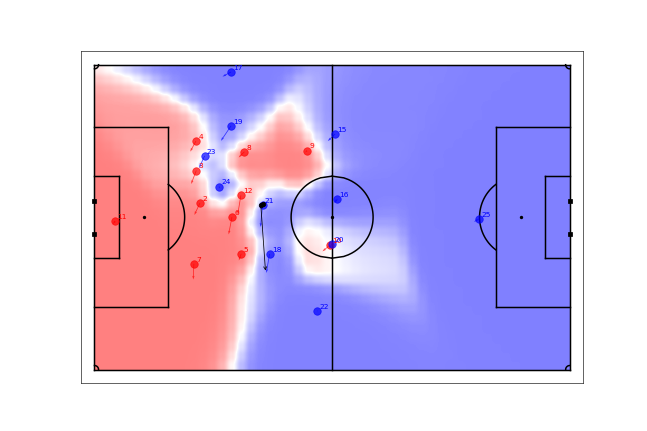

(<Figure size 720x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28ea49e7548>)

In [18]:
# Plus, the WHAT IF scenario... player 22 has not made that run, tucking in (instead)
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(1040, events, tracking_home, 
                                                        new_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
# plot pitch control surface for first pass
mviz.plot_pitchcontrol_for_event( 1040, events,  tracking_home, new_away, PPCF, xgrid, ygrid, annotate=True )

<h4> Pass probability for every Home team successful pass </h4> (look at the completed passes only)

In [19]:
# get all home passes
home_passes = events[ (events['Type'].isin(['PASS'])) & (events['Team']=='Home') ]

# newly-formed df shape (num of rows/passes, num of columns describe each pass)
home_passes.shape

(437, 14)

In [20]:
# list for storing pass probablities
pass_success_probability = []

for i,row in home_passes.iterrows():
    pass_start_pos = np.array([row['Start X'],row['Start Y']])
    pass_target_pos = np.array([row['End X'],row['End Y']])
    pass_frame = row['Start Frame']
    
    attacking_players = mpc.initialise_players(tracking_home.loc[pass_frame],'Home',params)
    defending_players = mpc.initialise_players(tracking_away.loc[pass_frame],'Away',params)
    # run the model, what the success probability at that instant was (for the pass to be completed)
    # Note that it's no longer has to go through this whole grid (as before, w/ n_grid_cells_x = 50...), but
    # (instead) just looking at the final location these passes actually made
    Patt,Pdef = mpc.calculate_pitch_control_at_target(pass_target_pos, attacking_players, 
                                                      defending_players, pass_start_pos, params)
    
    pass_success_probability.append( (i,Patt) )
    
# Essentially our aim, provide an estimate how risky were the passes the home team attempted...

In [21]:
# Set the backend of matplotlib to the 'inline' backend again 
%matplotlib inline 
# (no longer interactive output needed; used this before to inspect values on  pitch control surface )

Text(0, 0.5, 'Frequency')

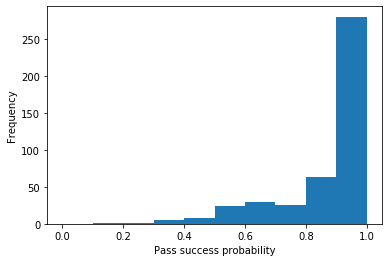

In [22]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.hist( [p[1] for p in pass_success_probability], np.arange(0,1.1,0.1))    
ax.set_xlabel('Pass success probability')
ax.set_ylabel('Frequency')  

As you can see most of the passes (250+) of home team had a success prob almost 0.9. Presumably, passes among defenders etc.

What we want to look at, is the number of passes completed w/ lower than 50% chance to be successful
from histogram;we can see that there were approximately 15-20 such risky passes:

In [23]:
# So, first sort the passes by pitch control probability:
pass_success_probability = sorted( pass_success_probability, key = lambda x: x[1] )

In [24]:
# identify the events corresponding to the most risky passes (pitch control < 0.5)
risky_passes = events.loc[ [p[0] for p in pass_success_probability if p[1]<0.5 ] ]
risky_passes

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
1303,Home,PASS,NaN,2,107585,4303.40,107688,4307.52,Player2,Player5,-22.26,-17.68,30.74,-27.88
1740,Home,PASS,NaN,2,143361,5734.44,143483,5739.32,Player12,Player13,-10.60,-11.56,32.86,30.60
657,Home,PASS,CROSS,1,53604,2144.16,53634,2145.36,Player7,Player8,49.82,-18.36,47.70,-0.00
1331,Home,PASS,NaN,2,108818,4352.72,108873,4354.92,Player5,Player10,-15.90,-26.52,-4.24,-19.04
361,Home,PASS,NaN,1,26590,1063.60,26608,1064.32,Player10,Player8,38.16,-10.88,47.70,-2.04
1528,Home,PASS,GOAL KICK,2,125558,5022.32,125677,5027.08,Player11,Player9,-50.88,-2.04,14.84,-26.52
348,Home,PASS,NaN,1,24980,999.20,25031,1001.24,Player4,Player10,-25.44,34.68,-16.96,27.20
1208,Home,PASS,CROSS,2,98958,3958.32,99005,3960.20,Player4,Player5,33.92,19.04,48.76,-9.52
570,Home,PASS,NaN,1,45835,1833.40,45904,1836.16,Player2,Player9,-13.78,-25.16,26.50,-24.48
33,Home,PASS,CROSS,1,2263,90.52,2289,91.56,Player10,Player9,41.34,24.48,44.52,2.04


(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28ea5f70e08>)

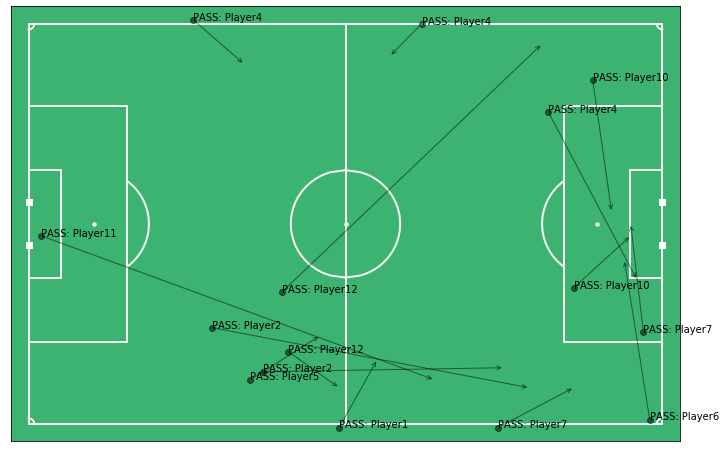

In [25]:
# plot the events that the Pitch Control model perceived as having less than 50% chance of being successful:
# remember Home team shoots from left to right:
mviz.plot_events( risky_passes, color='k', indicators = ['Marker','Arrow'], annotate=True )

In [26]:
# Plus, a look at events that followed those risky passes:
print("Event following a risky (completed) pass:")
for p in pass_success_probability[:20]:
    outcome = events.loc[ p[0]+1 ].Type
    print( p[1], outcome )

Event following a risky (completed) pass:
0.1928285366811617 BALL LOST
0.2613994613079421 PASS
0.3017512966226224 CHALLENGE
0.33426424544486044 PASS
0.3588084199656028 SHOT
0.37073032458628075 BALL LOST
0.3889833953061717 CHALLENGE
0.4075779527811081 SHOT
0.4357258445823139 CHALLENGE
0.43901460412830773 SHOT
0.44012433501673115 CHALLENGE
0.4429271999247692 CHALLENGE
0.4442572900734636 BALL LOST
0.4623362057611017 BALL OUT
0.47985546216714875 PASS
0.5070932924835223 PASS
0.5072230505298566 BALL LOST
0.5079238432781458 CHALLENGE
0.5128462384307616 CHALLENGE
0.5227867073730668 CHALLENGE
